# 💡 Simulação Contínua de Sinais EMG em Tempo Real

Este notebook simula um fluxo contínuo de sinais EMG (como em aquisição ao vivo), processando buffers de 1600 amostras em sequência.

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import stft
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from copy import deepcopy


## 🧰 Funções de Filtro e Extração de Características

In [57]:

def butter_bandpass(data, lowcut, highcut, fs=200, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='bandpass')
    return signal.filtfilt(b, a, data, padlen=len(data) // 2)

def butter_notch(data, cutoff, var=1, fs=200, order=4):
    nyq = fs * 0.5
    low = (cutoff - var) / nyq
    high = (cutoff + var) / nyq
    b, a = signal.iirfilter(order, [low, high], btype='bandstop', ftype="butter")
    return signal.filtfilt(b, a, data, padlen=len(data) // 2)

def var(x):
    return np.sum(x ** 2, axis=-1) / (np.prod(x.shape) - 1)

def rms(x):
    return np.sqrt(np.sum(np.abs(x) ** 2, axis=-1) / np.prod(x.shape))

def wl(x):
    return np.sum(np.abs(np.diff(x, axis=-1)), axis=-1)

def zc(x, threshold=1e-4):
    return np.sum(((x[..., :-1] * x[..., 1:]) < 0) & 
                  (np.abs(x[..., :-1] - x[..., 1:]) >= threshold), axis=-1)

def PSD(w):
    return np.abs(w) ** 2

def fmd(w):
    return np.sum(PSD(w), axis=-1) / 2

def mmdf(w):
    return np.sum(np.abs(w), axis=-1) / 2

def fmn(w, fs=200):
    freqs = np.linspace(0, fs / 2, w.shape[-1])
    return np.sum(freqs * PSD(w), axis=-1) / np.sum(PSD(w), axis=-1)

def mmnf(w, fs=200):
    freqs = np.linspace(0, fs / 2, w.shape[-1])
    return np.sum(freqs * np.abs(w), axis=-1) / np.sum(np.abs(w), axis=-1)


## 🔄 Função de Simulação em Tempo Real por Buffer

In [58]:
def simulate_realtime(buffer_data, clf, pca=None, fs=200, segment=256, step=103):
    data = buffer_data.T
    data = butter_notch(data, 60)
    data = butter_bandpass(data, 5., 50.)

    n_win = int((data.shape[-1] - segment) / step) + 1
    ids = np.arange(n_win) * step
    chunks_time = np.array([data[:, k:(k + segment)] for k in ids]).transpose(1, 0, 2)
    _, _, chunks_freq = stft(data, fs=fs, nperseg=segment, noverlap=128)
    chunks_freq = np.swapaxes(chunks_freq, 1, 2)

    features = []
    features.append(var(chunks_time))
    features.append(rms(chunks_time))
    features.append(wl(chunks_time))
    features.append(zc(chunks_time))
    features.append(fmd(chunks_freq))
    features.append(mmdf(chunks_freq))
    features.append(fmn(chunks_freq))
    features.append(mmnf(chunks_freq))
    features = np.array(features)  # (8, canais, janelas)
    vis = features.transpose(1, 2, 0)  # (canais, janelas, características)
    X = vis.transpose(1, 0, 2).reshape(vis.shape[1], -1)  # (janelas, 32)

    if pca:
        X = pca.transform(X)
    return clf.predict(X)


## 📦 Simulação com arquivo contínuo (12800, 4)

In [59]:

# 🔧 Exemplo de treinamento com arquivo s03_1.npy
raw_data = np.load("dataset/s03_1.npy")  # (8, 1600, 4)
raw_data = raw_data.transpose(0, 2, 1)   # (8, 4, 1600)

# Aplicar filtros
filtered = butter_notch(raw_data, 60)
filtered = butter_bandpass(filtered, 5., 50.)
data = deepcopy(filtered)

# Segmentação
step = 103
segment = 256
n_win = int((data.shape[-1] - segment) / step) + 1
ids = np.arange(n_win) * step
chunks_time = np.array([data[:, :, k:(k + segment)] for k in ids]).transpose(1, 2, 0, 3)
_, _, chunks_freq = stft(data, fs=200, nperseg=256, noverlap=128)
chunks_freq = np.swapaxes(chunks_freq, 2, 3)

# Extração de características
features = [
    var(chunks_time), rms(chunks_time), wl(chunks_time), zc(chunks_time),
    fmd(chunks_freq), mmdf(chunks_freq), fmn(chunks_freq), mmnf(chunks_freq)
]
features = np.array(features)
vis = features.transpose(1, 3, 2, 0)  # (8, 14, 4, 8)
X = vis.reshape(vis.shape[0] * vis.shape[1], vis.shape[2] * vis.shape[3])
y = np.repeat(np.arange(8), 14)

# Treinamento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)
clf = SVC(kernel='rbf', gamma='scale')
clf.fit(X_train, y_train)
print("✅ Classificador treinado com dados de s03_1.npy")

print("Características extraídas da primeira janela:")
print(X[0])  # vetor de 32 features (8 características x 4 canais)


✅ Classificador treinado com dados de s03_1.npy
Características extraídas da primeira janela:
[1.75275876e-02 1.32391219e-01 4.90686462e+02 7.70000000e+01
 1.27557646e+00 6.27616091e+00 1.88773477e+01 2.53703028e+01
 4.41001315e-02 2.09999398e-01 8.34886838e+02 7.30000000e+01
 2.51787693e+00 8.30476215e+00 2.81696935e+01 2.91396610e+01
 1.40760148e-02 1.18641865e-01 2.76298717e+02 6.00000000e+01
 3.80672472e+00 7.68489307e+00 1.04740945e+01 1.79354006e+01
 1.22017839e-02 1.10461204e-01 4.02900024e+02 7.50000000e+01
 1.72465663e+00 7.98075269e+00 2.35160550e+01 3.02113304e+01]


In [60]:
# Criação dataset  12800
data = np.load("dataset/s03_1.npy")  # (8, 1600, 4)
data_continuo = data.reshape(-1, 4)  # (12800, 4)
np.save("dataset/s01_continuo.npy", data_continuo)

# Substitua pelo caminho real do seu arquivo contínuo
raw_continuous = np.load("dataset/s03_continuo.npy")  # shape (12800, 4)

buffer_size = 1600
n_buffers = raw_continuous.shape[0] // buffer_size
all_preds = []

for i in range(n_buffers):
    print(f"Processando buffer {i+1}/{n_buffers}")
    start = i * buffer_size
    end = start + buffer_size
    buffer = raw_continuous[start:end, :]  # (1600, 4)

    preds = simulate_realtime(buffer, clf)
    pred_label = np.bincount(preds).argmax()
    all_preds.append(pred_label)

print("✅ Simulação finalizada!")
print("Predições por buffer:", all_preds)


Processando buffer 1/8
Processando buffer 2/8
Processando buffer 3/8
Processando buffer 4/8
Processando buffer 5/8
Processando buffer 6/8
Processando buffer 7/8
Processando buffer 8/8
✅ Simulação finalizada!
Predições por buffer: [np.int64(0), np.int64(1), np.int64(2), np.int64(2), np.int64(4), np.int64(3), np.int64(2), np.int64(2)]


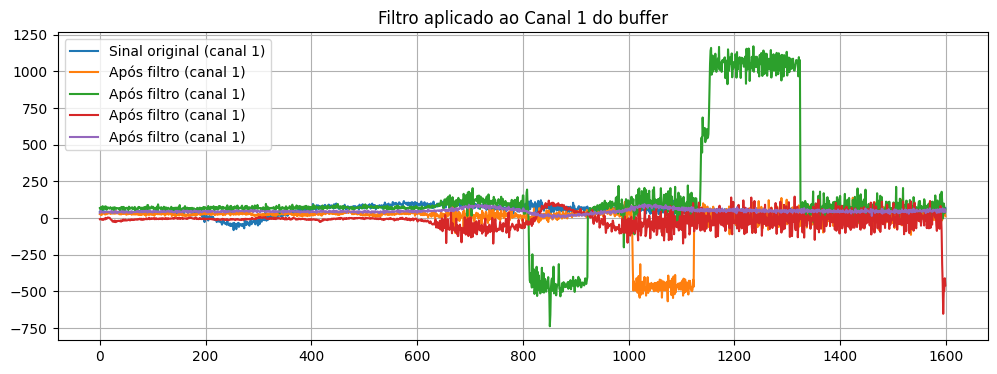

In [61]:
plt.figure(figsize=(12, 4))
plt.plot(buffer[:, 0], label='Sinal original (canal 1)')
plt.plot(data[0], label='Após filtro (canal 1)')
plt.title("Filtro aplicado ao Canal 1 do buffer")
plt.legend()
plt.grid(True)
plt.show()


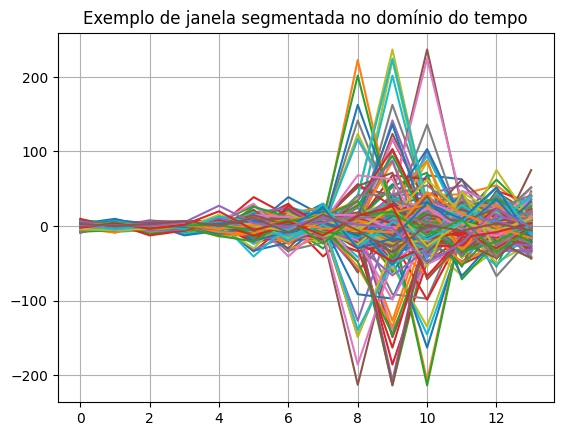

In [62]:
plt.plot(chunks_time[0, 0])  # canal 0, janela 0
plt.title("Exemplo de janela segmentada no domínio do tempo")
plt.grid(True)
plt.show()


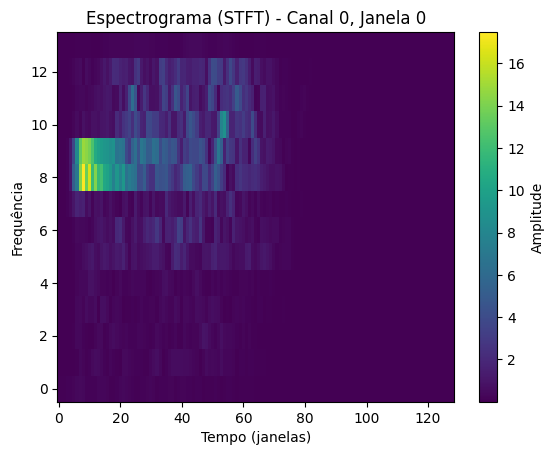

In [63]:
plt.imshow(np.abs(chunks_freq[0, 0]), aspect='auto', origin='lower')
plt.title("Espectrograma (STFT) - Canal 0, Janela 0")
plt.xlabel("Tempo (janelas)")
plt.ylabel("Frequência")
plt.colorbar(label='Amplitude')
plt.show()
